In [1]:
!pip install -q torch transformers

In [2]:
import pandas as pd
import numpy as np
import random
import torch
import ast
import os
import re
import csv
import json

import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

# Констант
RANDOM_STATE=654321

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_STATE)

# Загрузка и подготовка данных

## Загрузка датасет

In [4]:
df = pd.read_csv('train.csv', sep=';')

In [5]:
df.head(15)

,sample,annotation
0,aa,"[(0, 2, 'O')]"
1,aala,"[(0, 4, 'O')]"
2,aarcca,"[(0, 6, 'O')]"
3,abon,"[(0, 4, 'O')]"
4,abso,"[(0, 4, 'B-BRAND')]"
5,abtoys игруш,"[(0, 6, 'B-BRAND'), (7, 12, 'B-TYPE')]"
6,abtoys игрушк,"[(0, 6, 'B-BRAND'), (7, 13, 'B-TYPE')]"
7,abtoys игрушки,"[(0, 6, 'B-BRAND'), (7, 14, 'B-TYPE')]"
8,acofe,"[(0, 5, 'O')]"
9,actimal,"[(0, 7, 'B-BRAND')]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27251 entries, 0 to 27250
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sample      27251 non-null  object
 1   annotation  27251 non-null  object
dtypes: object(2)
memory usage: 425.9+ KB


## Преобразовать аннотацию в список кортежей

In [7]:
# Function to convert annotation string to tuples
def parse_annotations(annotation_str):
    # Use ast.literal_eval to safely convert string to list of tuples
    return ast.literal_eval(annotation_str)

# Apply the parsing function to the annotations column
df['annotations'] = df['annotation'].apply(parse_annotations)

In [8]:
# Function to flatten a list of tuples into separate columns
def flatten_ner(ner_list):
    flat_dict = {}
    for idx, (start, end, label) in enumerate(ner_list):
        flat_dict[f'start_{idx+1}'] = start
        flat_dict[f'end_{idx+1}'] = end
        flat_dict[f'label_{idx+1}'] = label
    return flat_dict

# Apply flattening function across the 'ner' column
df_flattened = pd.DataFrame(df['annotations'].apply(flatten_ner).tolist())

In [9]:
for col in df_flattened.columns:
    print(df_flattened[col].value_counts())

start_1
0    27248
1        3
Name: count, dtype: int64
end_1
7     5238
6     5038
8     4020
5     3699
4     2756
9     2286
3     1261
10    1168
11     591
12     511
13     188
2      167
14     109
15      84
16      47
1       40
17      20
18       9
21       9
20       4
19       3
28       2
22       1
Name: count, dtype: int64
label_1
B-TYPE     22826
B-BRAND     3604
O            821
Name: count, dtype: int64
start_2
7.0     2122
8.0     2120
6.0     1774
5.0     1561
9.0     1480
4.0      878
10.0     693
11.0     367
13.0     238
12.0     227
3.0       99
14.0      75
16.0      51
2.0       40
15.0      34
17.0      13
18.0       8
19.0       5
22.0       5
29.0       2
Name: count, dtype: int64
end_2
12.0    1504
13.0    1209
11.0    1146
14.0    1121
10.0    1030
15.0     994
16.0     827
9.0      801
8.0      655
17.0     561
18.0     471
7.0      355
19.0     310
20.0     205
6.0      166
21.0     119
22.0      92
5.0       79
23.0      55
24.0      34
25.0      20
2

Есть одна аномалия: класс 0 на самом деле не существует, это «О». Нам нужно это исправить.

In [10]:
df_flattened[df_flattened['label_3']=='0']

,start_1,end_1,label_1,start_2,end_2,label_2,start_3,end_3,label_3,start_4,end_4,label_4,start_5,end_5,label_5,start_6,end_6,label_6
4002,0,7,B-TYPE,8.0,9.0,O,10.0,17.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.iloc[4002]

sample                                      булочка с абрикос
annotation     [(0, 7, 'B-TYPE'), (8, 9, 'O'), (10, 17, '0')]
annotations          [(0, 7, B-TYPE), (8, 9, O), (10, 17, 0)]
Name: 4002, dtype: object

In [12]:
df.loc[4002, 'annotation'] = "[(0, 7, 'B-TYPE'), (8, 9, 'O'), (10, 17, 'O')]"

In [13]:
df['annotations'] = df['annotation'].apply(parse_annotations)

In [14]:
df.iloc[4002]

sample                                      булочка с абрикос
annotation     [(0, 7, 'B-TYPE'), (8, 9, 'O'), (10, 17, 'O')]
annotations          [(0, 7, B-TYPE), (8, 9, O), (10, 17, O)]
Name: 4002, dtype: object

## Количество символов и слов

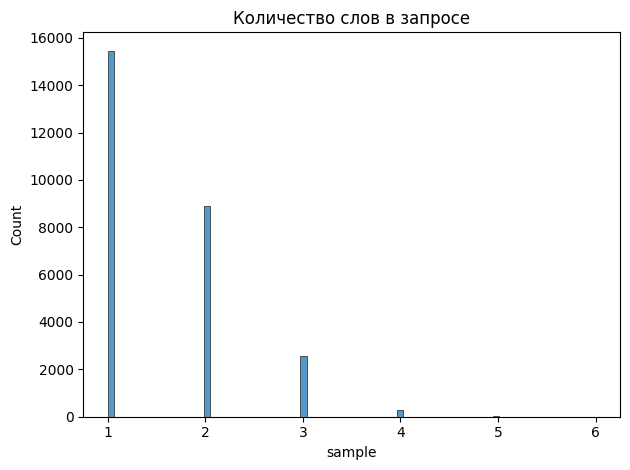

In [31]:
fig, axes = plt.subplotsfigsize=(15, 30)
sns.histplot(x=df['sample'].apply(lambda x : len(x.split())));
plt.title(f'Количество слов в запросе')
plt.tight_layout()

At maxМаксимум шесть слов на запрос

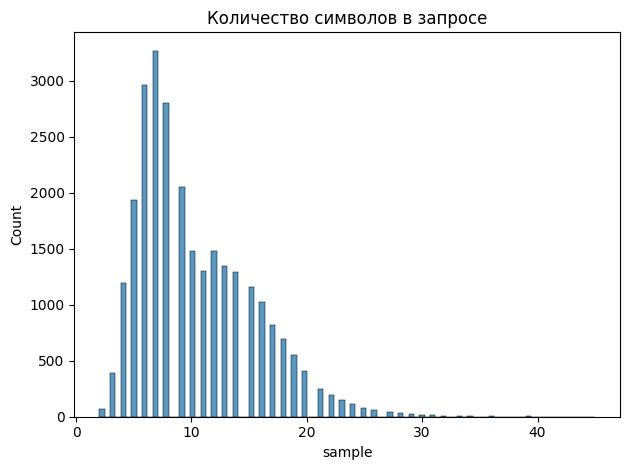

In [32]:
fig, axes = plt.subplotsfigsize=(15, 30)
sns.histplot(x=df['sample'].apply(lambda x : len(x)));
plt.title(f'Количество символов в запросе')
plt.tight_layout()

В среднем на один запрос приходится менее 10 символов.

В крайнем случае, если нам нужно разбить 6 слов на 3 подслова, нам понадобится 18 токенов. Поэтому, чтобы гарантированно получить все возможные слова, мы решили использовать 32 токена.

# Обучение модель

Для обучения у нас есть:

- часть токенизации:

    - Используемый токенизатор — AutoTokenizer, использует 'bert-base-multilingual-cased'                          
    - Поскольку запросы короткие, максимальная длина выбранного токена составила 32.
    - Каждый класс закодирован от 0 до 8.
    - Чтобы ограничить количество меток одной, во время токенизации номер метки присваивается только первой части слова, а остальным присваивается значение -100, как при заполнении. Токены со значением -100 не учитываются во время обучения.


- обучающая часть:

    - Содержит вес для каждого класса (класс индивидуального тренера)
    - Токенизация набора данных
    - Разделение набора данных на обучающий и валидационные. Мы выбрали размер тестового набора данных 10%. Фактически, мы обнаружили, что этот размер был оптимальным с точки зрения предоставления достаточного количества данных для обучения модели, а также для оценки и вычисления метрики. Метрика проверочного набора данных близка к той, что мы получили при офлайн-оценке (0,92).
    - Фаза обучения с использованием тренажёра из Hugging Face. Конечно, мы могли бы задать скорость обучения или контролировать снижение веса, но текущая конфигурация давала наилучшие результаты. Тренажер настроен таким образом, чтобы он получал модель с наилучшей метрикой f1 в ходе обучения.
    - Метрика f1 macro из функции compute_metrics

In [ ]:
# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to convert data to BERT format
def convert_to_bert_format(data, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []
    label_map = {}

    for idx, row in data.iterrows():
        text = row['sample']
        annotations = row['annotations']

        # Tokenize the text
        encodings = tokenizer(text, truncation=True, padding='max_length', max_length=32, is_split_into_words=False)
        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])

        # Create a new label array
        new_label_array = [-100] * len(encodings['input_ids'])  # Initialize with -100 (ignore padding)
        word_ids = encodings.word_ids(batch_index=0)

        for start, end, label in annotations:
            start_token = encodings.char_to_token(start)
            end_token = encodings.char_to_token(end - 1)
            if start_token is None or end_token is None:
                continue

            # Add label to the label_map
            if label not in label_map:
                label_map[label] = len(label_map)

            # Assign the label to the first token of the word
            for i in range(start_token, end_token + 1):
                if word_ids[i] == word_ids[start_token]:  # Same word
                    if i == start_token:  # First subword
                        new_label_array[i] = label_map[label]
                    else:  # Subsequent subwords
                        new_label_array[i] = -100  # Ignore
        labels.append(new_label_array)

    return input_ids, attention_masks, labels, label_map

# Custom Dataset Class
class TokenClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Custom Trainer Class to handle class weights
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, *args, **kwargs):
        labels = inputs.pop("labels")

        # Move inputs, labels, and class_weights to the device of the model
        device = model.device  # Get the model's device (cuda or cpu)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        if self.class_weights is not None:
            # Move class_weights to the same device
            self.class_weights = self.class_weights.to(device)

        # Forward pass to get logits
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Define training and evaluation
def train(df):
    # Example for 10 classes
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    # {0: 'O', 1: 'B-BRAND', 2: 'B-TYPE', 3: 'I-BRAND', 4: 'I-TYPE', 5: 'B-PERCENT', 6: 'B-VOLUME', 7: 'I-VOLUME', 8: 'I-PERCENT'}

    # Prepare dataset
    input_ids, attention_masks, labels, label_map = convert_to_bert_format(df, tokenizer)
    dataset = TokenClassificationDataset(input_ids, attention_masks, labels)

    # Create id2label mapping
    id2label = {v: k for k, v in label_map.items()}

    # Save the label_map for later evaluation
    os.makedirs('./saved_model', exist_ok=True)
    with open('./saved_model/label_map.json', 'w') as f:
        json.dump(label_map, f)

    # Split the dataset into train and validation sets
    train_dataset, val_dataset = train_test_split(dataset, test_size=0.1)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Load the pre-trained model
    model = AutoModelForTokenClassification.from_pretrained(
        'bert-base-multilingual-cased',
        num_labels=len(label_map),  # Set this dynamically based on label_map
    )

    # Move model to the correct device (GPU or CPU)
    model.to(device)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',  # where to save model
        num_train_epochs=10,  # number of training epochs
        per_device_train_batch_size=16,  # batch size for training
        per_device_eval_batch_size=16,  # batch size for evaluation
        eval_strategy="epoch",  # evaluate every epoch
        save_strategy="epoch",  # save the model every epoch
        logging_dir='./logs',  # where to save logs
        logging_steps=10,  # log every 10 steps
        load_best_model_at_end=True,  # load the best model at the end of training
        metric_for_best_model="f1",  # use F1 score to determine best model
        greater_is_better=True,
    )

    # Compute metrics
    def compute_metrics(pred):
        pred_labels = pred.predictions.argmax(axis=-1)
        true_labels = pred.label_ids

        # Initialize lists to hold the true and predicted labels after filtering padding tokens
        true_labels_filtered = []
        pred_labels_filtered = []

        for true_seq, pred_seq in zip(true_labels, pred_labels):
            true_seq_filtered = []
            pred_seq_filtered = []
            for true_label, pred_label in zip(true_seq, pred_seq):
                if true_label != -100:
                    true_seq_filtered.append(true_label)
                    pred_seq_filtered.append(pred_label)

            true_labels_filtered.append(true_seq_filtered)
            pred_labels_filtered.append(pred_seq_filtered)

        true_labels_converted = [[id2label[label] for label in seq] for seq in true_labels_filtered]
        pred_labels_converted = [[id2label[label] for label in seq] for seq in pred_labels_filtered]

        with open('./true_and_predicted_labels.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            if file.tell() == 0:
                writer.writerow(['true_labels', 'predictions'])
            for true, pred in zip(true_labels_converted, pred_labels_converted):
                writer.writerow([true, pred])

        precision = precision_score(true_labels_converted, pred_labels_converted, average='macro')
        recall = recall_score(true_labels_converted, pred_labels_converted, average='macro')
        f1 = f1_score(true_labels_converted, pred_labels_converted, average='macro')

        return {'precision': precision, 'recall': recall, 'f1': f1}

    # Instantiate the CustomTrainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    # Train the model
    trainer.train()

    # Save the model after training
    os.makedirs('./saved_model', exist_ok=True)
    model.save_pretrained('./saved_model')
    tokenizer.save_pretrained('./saved_model')

    # Evaluate the model on the validation set
    results = trainer.evaluate()
    print(results)

# Example of how to call the train and evaluate function
train(df)

Training on device: cuda


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.419300,0.264847,0.543501,0.704343,0.586655
2,0.305400,0.238512,0.815311,0.798329,0.738378
3,0.135300,0.328749,0.795477,0.877046,0.827780
4,0.136600,0.343522,0.780462,0.799242,0.782849
5,0.038300,0.363743,0.850139,0.881764,0.842967
6,0.045000,0.394863,0.954733,0.880800,0.909358
7,0.045500,0.432057,0.876301,0.881866,0.862399
8,0.063300,0.486399,0.878411,0.882119,0.863571
9,0.017800,0.516118,0.880047,0.879735,0.863147
10,0.002100,0.533621,0.879618,0.882221,0.864217


{'eval_loss': 0.3948628604412079, 'eval_precision': 0.9547326058354617, 'eval_recall': 0.8808001893939393, 'eval_f1': 0.9093581218564921, 'eval_runtime': 2.9955, 'eval_samples_per_second': 910.042, 'eval_steps_per_second': 57.086, 'epoch': 10.0}


Мы видим, что в ходе обучения модель достигла пика в 91% по метрике f1, а затем перестала расти. Наша модель показала лучшую метрику на эпохе 6 - (f1 = 91%).

## Анализ результата с использованием проверочного набора данных

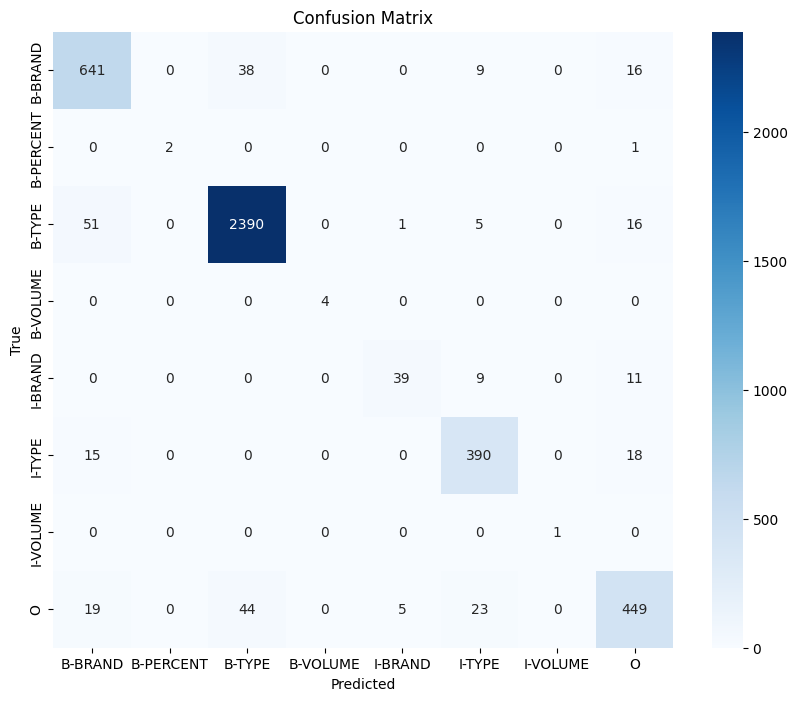

In [ ]:
# Load the CSV file with true and predicted labels
df_val = pd.read_csv('./true_and_predicted_labels.csv')

# Clean and split the string representations of lists
# We convert the string representation of lists into actual lists
df_val['true_labels'] = df_val['true_labels'].apply(lambda x: eval(x))  # Convert string to list
df_val['predictions'] = df_val['predictions'].apply(lambda x: eval(x))  # Convert string to list

# Flatten the true and predicted labels (i.e., flatten token-level labels into a single list)
true_labels_flat = [item for sublist in df_val['true_labels'] for item in sublist]
pred_labels_flat = [item for sublist in df_val['predictions'] for item in sublist]

# Create confusion matrix
cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=np.unique(true_labels_flat))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_flat), yticklabels=np.unique(true_labels_flat))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Это матрица последней эпохи обучения. Мы видим, что в целом модель выполняет свою работу хорошо.
Очевидно, что у нас много ложноотрицательных и ложноположительных результатов как для класса "O", так и для бренда, поэтому мы постарались поработать над ними.
Мы попробовали заменить вес для класса "O" и опробовали аугментацию данных по бренду, но ничего не работает, объясним подробнее в следующей части.

## Улучшение модели

Чтобы улучшить модель, мы попробовали разные методы:

- Изменяя вес, как мы видели в матрице ошибок, мы заметили, что, вероятно, если придать больше веса одному классу, чем другому, это улучшит модель. Однако, это не так. Вероятно, это не сработало, потому что вес влияет на функцию потерь, а мы используем f1 для оптимизации тренировки, а не функцию потерь.
- Коррекция набора данных. Как мы видели в наборе данных, у нас есть систематические ошибки, которые будут повторяться, например:
  
        nemoliko;[(0, 8, 'B-BRAND')]
        nemolkoko;[(0, 9, 'B-TYPE')]
        nemolok;[(0, 7, 'B-TYPE')]
        nemoloki;[(0, 8, 'B-TYPE')]
        nemoloko;[(0, 8, 'B-TYPE')]
  
для бренда «Немолоко». Мы видим, что в качестве бренда выбран nemoliko;[(0, 8, 'B-BRAND')], хотя мы могли бы подумать, что брендом должен быть nemoloko;[(0, 8, 'B-TYPE')]. Так как, вероятно, это систематическая ошибка, мы не исправили и не удалили такие ошибки в наборе данных, чтобы не навредить обобщению.

  Есть также некоторые ошибки, такие как:
  
        молоко село з;[(0, 6, 'B-TYPE'), (7, 11, 'B-BRAND'), (12, 13, 'I-BRAND')],
        молоко село зеле;[(0, 6, 'B-TYPE'), (7, 11, 'O'), (12, 16, 'O')]
где бренд также был определён как "О"-категория. Мы не исправляли эти ошибки, поскольку увидели, что наша модель достаточно хорошо прогнозирует правильный бренд даже с учётом ошибок в обучающем фрейме данных.
  
- Аугментирование данных. Мы попробовали другую стратегию для дополнения данных:
    - инвертирование продукта и бренда (проблема контекста)
    - брали иностранные бренды, переводили их на русский, добавляли опечатку (замена одной буквы на соседнюю, пропуск одной буквы, повтор одной буквы)
    - ассоциирование любого бренда с любым продуктом (проблема контекста)
    - ассоциирование бренда с типом продукта, относящимся к бренду

После всех наших попыток нам не удалось увеличить оценку нашей модели. Каждый раз оценка проверки снижалась или переобучалась, и на тестовом наборе данных мы видели низкую метрику.

## Попытка с использованием дополнения данных о бренде

Мы выбрали все иностранные названия, перевели их на русский язык, а затем провели некоторые преобразования (пропуск букв, замена букв соседними, повторение букв) для первой части слова (3 первых буквы) для слов, содержащих 3 и более букв.

In [ ]:
def is_latin(word):
    # Check if the word contains only Latin letters
    return bool(re.match('^[a-zA-Z]+$', word))

def transform_to_desired_format(query, annotations):
    #print(f"Processing query: {query}")
    #print(f"Annotations: {annotations}")

    # Split query into words
    words = query.split()
    word_positions = []
    current_pos = 0

    # Calculate word positions
    for word in words:
        word_positions.append((word, current_pos, current_pos + len(word)))
        current_pos += len(word) + 1  # +1 for space

    #print(f"Word positions: {word_positions}")

    # Prepare result
    result = []

    # Match words with annotations
    for word, start, end in word_positions:
        if is_latin(word):
           #print(f"Checking word: {word} ({start}, {end})")
            for annotation in annotations:
                #print(f"  Checking annotation: {annotation}")
                if start >= annotation[0] and end <= annotation[1] + 1:
                    result.append((word, annotation[0], annotation[1], annotation[2]))
                   # print(f"  Match found: {word}, {annotation}")
                    break

    #print(f"Result: {result}")
    return result

# Apply transformation
df['result'] = df.apply(lambda row: transform_to_desired_format(row['sample'], row['annotations']), axis=1)

# Explode the list of tuples into separate rows
result_df = df.explode('result').reset_index(drop=True)

# Separate word and annotation tuple
result_df[['word', 'start', 'end', 'label']] = pd.DataFrame(result_df['result'].tolist(), index=result_df.index)

# Drop unnecessary columns
result_df = result_df[['word', 'label']]

print(result_df)

         word    label
0          aa        O
1        aala        O
2      aarcca        O
3        abon        O
4        abso  B-BRAND
...       ...      ...
27351     NaN     None
27352     NaN     None
27353     NaN     None
27354     NaN     None
27355     NaN     None

[27356 rows x 2 columns]


In [ ]:
result_df_eng = result_df.dropna()

In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27356 entries, 0 to 27355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    3857 non-null   object
 1   label   3857 non-null   object
dtypes: object(2)
memory usage: 427.6+ KB


In [ ]:
result_df_eng['len_word'] = result_df_eng['word'].apply(lambda x: len(x))

In [ ]:
# Removing duplicates
result_df_eng.duplicated().sum()

1324

In [ ]:
result_df_eng = result_df_eng.drop_duplicates()

In [ ]:
result_df_eng = result_df_eng.query('label == "B-BRAND" and len_word > 3')

In [ ]:
# Define the Russian keyboard layout
keyboard_layout = keyboard_layout = {
    'й': ['ц', 'у'],
    'ц': ['й', 'у', 'ы'],
    'у': ['й', 'ц', 'к', 'е'],
    'к': ['у', 'е', 'н'],
    'е': ['у', 'к', 'г', 'н', 'ш'],
    'н': ['е', 'г', 'щ', 'ш', 'з'],
    'г': ['е', 'н', 'щ', 'з', 'х'],
    'ш': ['н', 'з', 'х', 'ъ'],
    'щ': ['н', 'г', 'з', 'х', 'ъ'],
    'з': ['н', 'щ', 'х', 'ъ', 'ы'],
    'х': ['г', 'щ', 'з', 'ъ', 'ы'],
    'ъ': ['ш', 'щ', 'з', 'х', 'ы'],
    'ф': ['ы', 'в', 'а'],
    'ы': ['й', 'ц', 'ф', 'в', 'а'],
    'в': ['ы', 'ф', 'а', 'п'],
    'а': ['ы', 'ф', 'в', 'п', 'р'],
    'п': ['в', 'а', 'р', 'о'],
    'р': ['а', 'п', 'о', 'л'],
    'о': ['п', 'р', 'л', 'д'],
    'л': ['р', 'о', 'д', 'ж'],
    'д': ['о', 'л', 'ж', 'э'],
    'ж': ['л', 'д', 'э', 'я'],
    'э': ['д', 'ж', 'я'],
    'я': ['ж', 'э', 'ч'],
    'ч': ['я', 'с', 'м'],
    'с': ['ч', 'м', 'и'],
    'м': ['ч', 'с', 'и', 'т'],
    'и': ['с', 'м', 'т', 'ь'],
    'т': ['м', 'и', 'ь', 'б'],
    'ь': ['и', 'т', 'б', 'ю'],
    'б': ['т', 'ь', 'ю'],
    'ю': ['ь', 'б']
}

# Transliteration dictionary from English to Russian
translit_dict = {
    'a': 'а', 'b': 'б', 'c': 'с', 'd': 'д', 'e': 'е',
    'f': 'ф', 'g': 'г', 'h': 'х', 'i': 'и', 'j': 'й',
    'k': 'к', 'l': 'л', 'm': 'м', 'n': 'н', 'o': 'о',
    'p': 'п', 'q': 'к', 'r': 'р', 's': 'с', 't': 'т',
    'u': 'у', 'v': 'в', 'w': 'в', 'x': 'кс', 'y': 'и',
    'z': 'з'
}

def transliterate(word):
    """Convert English word to Russian"""
    return ''.join(translit_dict.get(char.lower(), char) for char in word)

def generate_adjacent_typo(word):
    if len(word) < 3:
        return word
    position = random.randint(0, 2)
    char = word[position]
    adjacent_chars = keyboard_layout.get(char.lower(), [])
    if not adjacent_chars:
        return word
    new_char = random.choice(adjacent_chars)
    return word[:position] + new_char + word[position+1:]

def generate_double_typo(word):
    if len(word) < 3:
        return word
    position = random.randint(0, 2)
    return word[:position+1] + word[position] + word[position+1:]

def generate_skipped_typo(word):
    if len(word) < 3:
        return word
    position = random.randint(0, 2)
    return word[:position] + word[position+1:]

def process_word(word):
    results = []
    # Transliterate first
    russian_word = transliterate(word)
    # Original word
    results.append(russian_word)
    # # Adjacent typo
    results.append(generate_adjacent_typo(russian_word))
    # Double typo
    results.append(generate_double_typo(russian_word))
    # Skipped typo
    results.append(generate_skipped_typo(russian_word))
    return results

def create_dataframe(words):
    data = []
    for original_word in words:
        processed_words = process_word(original_word)
        for word in processed_words:
            start_index = 0
            end_index = len(word)
            data.append({
                'word': word,
                'start_index': start_index,
                'end_index': end_index,
                'label': 'B-BRAND'
            })
    return pd.DataFrame(data)


result_df = create_dataframe(result_df_eng['word'])

In [ ]:
def transform_to_final_format(df):
    # Create the new format with 'sample' and 'annotations'
    transformed_data = []
    for index, row in df.iterrows():
        word = row['word']
        start = row['start_index']
        end = row['end_index']
        label = row['label']
        transformed_data.append({
            'sample': word,
            'annotations': [(start, end, label)]
        })
    return pd.DataFrame(transformed_data)

In [ ]:
result_df = transform_to_final_format(result_df)

In [ ]:
df_augm = pd.concat([df.drop(['annotation', 'result'], axis=1), result_df], axis=0)

In [ ]:
df_augm = df_augm.drop_duplicates(['sample'])

In [ ]:
# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to convert data to BERT format
def convert_to_bert_format(data, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []
    label_map = {}

    for idx, row in data.iterrows():
        text = row['sample']
        annotations = row['annotations']

        # Tokenize the text
        encodings = tokenizer(text, truncation=True, padding='max_length', max_length=32, is_split_into_words=False)
        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])

        # Create a new label array
        new_label_array = [-100] * len(encodings['input_ids'])  # Initialize with -100 (ignore padding)
        word_ids = encodings.word_ids(batch_index=0)

        for start, end, label in annotations:
            start_token = encodings.char_to_token(start)
            end_token = encodings.char_to_token(end - 1)
            if start_token is None or end_token is None:
                continue

            # Add label to the label_map
            if label not in label_map:
                label_map[label] = len(label_map)

            # Assign the label to the first token of the word
            for i in range(start_token, end_token + 1):
                if word_ids[i] == word_ids[start_token]:  # Same word
                    if i == start_token:  # First subword
                        new_label_array[i] = label_map[label]
                    else:  # Subsequent subwords
                        new_label_array[i] = -100  # Ignore
        labels.append(new_label_array)

    return input_ids, attention_masks, labels, label_map

# Custom Dataset Class
class TokenClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Custom Trainer Class to handle class weights
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, *args, **kwargs):
        labels = inputs.pop("labels")

        # Move inputs, labels, and class_weights to the device of the model
        device = model.device  # Get the model's device (cuda or cpu)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        if self.class_weights is not None:
            # Move class_weights to the same device
            self.class_weights = self.class_weights.to(device)

        # Forward pass to get logits
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Define training and evaluation
def train(df):
    # Example for 10 classes
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    # {0: 'O', 1: 'B-BRAND', 2: 'B-TYPE', 3: 'I-BRAND', 4: 'I-TYPE', 5: 'B-PERCENT', 6: 'B-VOLUME', 7: 'I-VOLUME', 8: 'I-PERCENT'}

    # Prepare dataset
    input_ids, attention_masks, labels, label_map = convert_to_bert_format(df, tokenizer)
    dataset = TokenClassificationDataset(input_ids, attention_masks, labels)

    # Create id2label mapping
    id2label = {v: k for k, v in label_map.items()}

    # Save the label_map for later evaluation
    os.makedirs('./saved_model_data_augm', exist_ok=True)
    with open('./saved_model_data_augm/label_map.json', 'w') as f:
        json.dump(label_map, f)

    # Split the dataset into train and validation sets
    train_dataset, val_dataset = train_test_split(dataset, test_size=0.1)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Load the pre-trained model
    model = AutoModelForTokenClassification.from_pretrained(
        'bert-base-multilingual-cased',
        num_labels=len(label_map),  # Set this dynamically based on label_map
    )

    # Move model to the correct device (GPU or CPU)
    model.to(device)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',  # where to save model
        num_train_epochs=10,  # number of training epochs
        per_device_train_batch_size=16,  # batch size for training
        per_device_eval_batch_size=16,  # batch size for evaluation
        eval_strategy="epoch",  # evaluate every epoch
        save_strategy="no",  # save the model every epoch
        logging_dir='./logs',  # where to save logs
        logging_steps=10,  # log every 10 steps
        #load_best_model_at_end=True,  # load the best model at the end of training
        metric_for_best_model="f1",  # use F1 score to determine best model
        greater_is_better=True,
    )

    # Compute metrics
    def compute_metrics(pred):
        pred_labels = pred.predictions.argmax(axis=-1)
        true_labels = pred.label_ids

        # Initialize lists to hold the true and predicted labels after filtering padding tokens
        true_labels_filtered = []
        pred_labels_filtered = []

        for true_seq, pred_seq in zip(true_labels, pred_labels):
            true_seq_filtered = []
            pred_seq_filtered = []
            for true_label, pred_label in zip(true_seq, pred_seq):
                if true_label != -100:
                    true_seq_filtered.append(true_label)
                    pred_seq_filtered.append(pred_label)

            true_labels_filtered.append(true_seq_filtered)
            pred_labels_filtered.append(pred_seq_filtered)

        true_labels_converted = [[id2label[label] for label in seq] for seq in true_labels_filtered]
        pred_labels_converted = [[id2label[label] for label in seq] for seq in pred_labels_filtered]

        precision = precision_score(true_labels_converted, pred_labels_converted, average='macro')
        recall = recall_score(true_labels_converted, pred_labels_converted, average='macro')
        f1 = f1_score(true_labels_converted, pred_labels_converted, average='macro')

        return {'precision': precision, 'recall': recall, 'f1': f1}

    # Instantiate the CustomTrainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    # Train the model
    trainer.train()

    # Save the model after training
    os.makedirs('./saved_model_data_augm', exist_ok=True)
    model.save_pretrained('./saved_model_data_augm')
    tokenizer.save_pretrained('./saved_model_data_augm')

    # Evaluate the model on the validation set
    results = trainer.evaluate()
    print(results)

# Example of how to call the train and evaluate function
train(df_augm)

Training on device: cuda


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.273600,0.340531,0.565823,0.596677,0.580092
2,0.239900,0.330777,0.562088,0.659750,0.598166
3,0.093900,0.392512,0.642767,0.604727,0.621428
4,0.203700,0.367062,0.565228,0.613952,0.585996
5,0.037500,0.470912,0.641378,0.613234,0.625156
6,0.028200,0.415403,0.614093,0.714046,0.653228
7,0.064400,0.483860,0.626172,0.666160,0.644627
8,0.013000,0.555842,0.602775,0.663499,0.628354
9,0.005400,0.599970,0.603678,0.666778,0.630443
10,0.014300,0.613057,0.604041,0.665954,0.630215


{'eval_loss': 0.6130567789077759, 'eval_precision': 0.6040411548247264, 'eval_recall': 0.6659543433550144, 'eval_f1': 0.6302145687743037, 'eval_runtime': 3.806, 'eval_samples_per_second': 912.76, 'eval_steps_per_second': 57.277, 'epoch': 10.0}


Мы могли бы скорректировать номер эпохи и попытаться получить лучшую метрику, но здесь мы ясно видим, что наше дополнение данных создало некоторый шум.

## Попытка с измением веса для класса "O"


In [ ]:
# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to convert data to BERT format
def convert_to_bert_format(data, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []
    label_map = {}

    for idx, row in data.iterrows():
        text = row['sample']
        annotations = row['annotations']

        # Tokenize the text
        encodings = tokenizer(text, truncation=True, padding='max_length', max_length=32, is_split_into_words=False)
        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])

        # Create a new label array
        new_label_array = [-100] * len(encodings['input_ids'])  # Initialize with -100 (ignore padding)
        word_ids = encodings.word_ids(batch_index=0)

        for start, end, label in annotations:
            start_token = encodings.char_to_token(start)
            end_token = encodings.char_to_token(end - 1)
            if start_token is None or end_token is None:
                continue

            # Add label to the label_map
            if label not in label_map:
                label_map[label] = len(label_map)

            # Assign the label to the first token of the word
            for i in range(start_token, end_token + 1):
                if word_ids[i] == word_ids[start_token]:  # Same word
                    if i == start_token:  # First subword
                        new_label_array[i] = label_map[label]
                    else:  # Subsequent subwords
                        new_label_array[i] = -100  # Ignore
        labels.append(new_label_array)

    return input_ids, attention_masks, labels, label_map

# Custom Dataset Class
class TokenClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Custom Trainer Class to handle class weights
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, *args, **kwargs):
        labels = inputs.pop("labels")

        # Move inputs, labels, and class_weights to the device of the model
        device = model.device  # Get the model's device (cuda or cpu)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        if self.class_weights is not None:
            # Move class_weights to the same device
            self.class_weights = self.class_weights.to(device)

        # Forward pass to get logits
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Define training and evaluation
def train(df):
    # Example for 10 classes
    class_weights = torch.tensor([0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    # {0: 'O', 1: 'B-BRAND', 2: 'B-TYPE', 3: 'I-BRAND', 4: 'I-TYPE', 5: 'B-PERCENT', 6: 'B-VOLUME', 7: 'I-VOLUME', 8: 'I-PERCENT'}

    # Prepare dataset
    input_ids, attention_masks, labels, label_map = convert_to_bert_format(df, tokenizer)
    dataset = TokenClassificationDataset(input_ids, attention_masks, labels)

    # Create id2label mapping
    id2label = {v: k for k, v in label_map.items()}

    # Save the label_map for later evaluation
    os.makedirs('./saved_model_w', exist_ok=True)
    with open('./saved_model_w/label_map.json', 'w') as f:
        json.dump(label_map, f)

    # Split the dataset into train and validation sets
    train_dataset, val_dataset = train_test_split(dataset, test_size=0.1)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Load the pre-trained model
    model = AutoModelForTokenClassification.from_pretrained(
        'bert-base-multilingual-cased',
        num_labels=len(label_map),  # Set this dynamically based on label_map
    )

    # Move model to the correct device (GPU or CPU)
    model.to(device)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',  # where to save model
        num_train_epochs=10,  # number of training epochs
        per_device_train_batch_size=16,  # batch size for training
        per_device_eval_batch_size=16,  # batch size for evaluation
        eval_strategy="epoch",  # evaluate every epoch
        save_strategy="epoch",  # save the model every epoch
        logging_dir='./logs',  # where to save logs
        logging_steps=10,  # log every 10 steps
        load_best_model_at_end=True,  # load the best model at the end of training
        metric_for_best_model="f1",  # use F1 score to determine best model
        greater_is_better=True,
    )

    # Compute metrics
    def compute_metrics(pred):
        pred_labels = pred.predictions.argmax(axis=-1)
        true_labels = pred.label_ids

        # Initialize lists to hold the true and predicted labels after filtering padding tokens
        true_labels_filtered = []
        pred_labels_filtered = []

        for true_seq, pred_seq in zip(true_labels, pred_labels):
            true_seq_filtered = []
            pred_seq_filtered = []
            for true_label, pred_label in zip(true_seq, pred_seq):
                if true_label != -100:
                    true_seq_filtered.append(true_label)
                    pred_seq_filtered.append(pred_label)

            true_labels_filtered.append(true_seq_filtered)
            pred_labels_filtered.append(pred_seq_filtered)

        true_labels_converted = [[id2label[label] for label in seq] for seq in true_labels_filtered]
        pred_labels_converted = [[id2label[label] for label in seq] for seq in pred_labels_filtered]

        precision = precision_score(true_labels_converted, pred_labels_converted, average='macro')
        recall = recall_score(true_labels_converted, pred_labels_converted, average='macro')
        f1 = f1_score(true_labels_converted, pred_labels_converted, average='macro')

        return {'precision': precision, 'recall': recall, 'f1': f1}

    # Instantiate the CustomTrainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    # Train the model
    trainer.train()

    # Save the model after training
    os.makedirs('./saved_model_w', exist_ok=True)
    model.save_pretrained('./saved_model_w')
    tokenizer.save_pretrained('./saved_model_w')

    # Evaluate the model on the validation set
    results = trainer.evaluate()
    print(results)

# Example of how to call the train and evaluate function
train(df)

Training on device: cuda


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.266700,0.309197,0.452708,0.698605,0.474936
2,0.193300,0.267049,0.522288,0.486885,0.495271
3,0.214700,0.293681,0.560380,0.761644,0.563235
4,0.088200,0.334189,0.667805,0.851341,0.692495
5,0.126900,0.286158,0.904566,0.968441,0.933232
6,0.034300,0.328718,0.783330,0.945818,0.842223
7,0.001000,0.391941,0.726353,0.902141,0.772534
8,0.022100,0.397906,0.712590,0.899596,0.749808
9,0.040500,0.426708,0.778117,0.924055,0.829872
10,0.025000,0.460930,0.730690,0.900716,0.774022


{'eval_loss': 0.2861580550670624, 'eval_precision': 0.9045663908763302, 'eval_recall': 0.9684412250116157, 'eval_f1': 0.9332319146980421, 'eval_runtime': 3.0098, 'eval_samples_per_second': 905.705, 'eval_steps_per_second': 56.814, 'epoch': 10.0}


Здесь модель серьезно переобучилась (набрала 93% на валидационном датасете и 79% на тестовых данных).

# Заключение

На этапе предварительной обработки мы удалили лишний класс, который у нас был ("О").

Мы пробовали разные модели, и лучшей моделью оказалась «bert-base-multilingual-cased».

В процессе поиска наилучшей модели мы обнаружили, что дополнение данных и исправление ошибок, а также изменение веса для каждого класса не дали хорошего результата, вероятно, из-за генерируемого шума. Скорее всего, BERT действительно получил всё, что мог, из нашего набора данных, и только удаление или добавление новых данных смогло бы улучшить метрику. Еще одной проблемой является наличие систематических ошибок в обучающем наборе данных. Удаление таких ошибок может быть опасным для обобщения и, возможно, бесполезным, поскольку наша модель могла правильно предсказывать результаты даже при неверно размеченных запросах. Добавление новых данных было невозможно, так как мы не смогли найти подходящий набор данных, а создание собственных данных было запрещено.

Вот почему мы решили сохранить нашу базовую модель, обученную на предоставленном наборе данных для конкурса, полагая, что она будет лучшей для обобщения.